In [1]:
%matplotlib inline
# Python libraries

import os, cv2, itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from glob import glob
from PIL import Image

# Pytorch libraries
import torch
from torch import optim, nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms

# sklearn libraries
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# to make the results are reproducible
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

print(os.listdir('../data'))

['MNIST', 'image_processing_templates.ipynb', '.ipynb_checkpoints', 'table.csv', 'images', '.DS_Store']


In [2]:
directory = '../data/images/'

image_path = glob(os.path.join(directory, '*.jpg'))
imageid = {os.path.splitext(os.path.basename(x))[0]: x for x in image_path}
print(len(image_path))

18997


In [3]:
lesion_type = {
    'MEL': 'Melanoma',
    'NV': 'Naevus',
    'BCC': 'Basal Cell Carcinoma',
    'AK': 'IEC/Bowens disease',
    'BKL': 'Seborrhoeic keratosis',
    'DF': 'dermatofibroima',
    'VASC': 'vascular lesions',
    'SCC': 'Squamous cell carcinom',
    'UNK': 'Keratosis pilaris'
}

lesion_category = {
    'MEL': 0,
    'NV':  1,
    'BCC': 2,
    'AK':  3,
    'BKL': 4,
    'DF':  5,
    'VASC': 6,
    'SCC': 7,
    'UNK': 8
}

In [4]:
def compute_img_mean_std(image_paths):
    """
        computing the mean and std of three channel on the whole dataset,
        first we should normalize the image from 0-255 to 0-1
    """

    img_h, img_w = 224, 224
    imgs = []
    means, stdevs = [], []

    for i in tqdm(range(len(image_paths))):
        img = cv2.imread(image_paths[i])
        img = cv2.resize(img, (img_h, img_w))
        imgs.append(img)

    imgs = np.stack(imgs, axis=3)
    print(imgs.shape)

    imgs = imgs.astype(np.float32) / 255.

    for i in range(3):
        pixels = imgs[:, :, i, :].ravel()  # resize to one row
        means.append(np.mean(pixels))
        stdevs.append(np.std(pixels))

    means.reverse()  # BGR --> RGB
    stdevs.reverse()

    print("normMean = {}".format(means))
    print("normStd = {}".format(stdevs))
    return means,stdevs

#norm_mean, norm_std = compute_img_mean_std(image_path)
# shape (224, 224, 3, 18997)
norm_mean = [0.7851518, 0.6649233, 0.6525781]
norm_std = [0.17073259, 0.21847703, 0.2293689]

In [26]:
df = pd.read_csv('table.csv')
lesion_code_list = lesion_type.keys()
df['path'] = df['image'].map(imageid.get)
df['cell_type'] = df[lesion_code_list].idxmax(axis=1).map(lesion_type.get)
df['cell_type_idx'] = df[lesion_code_list].idxmax(axis=1).map(lesion_category.get)
print(df.shape)
bool_series = pd.isnull(df["image"])  
df[bool_series]

(18997, 24)


,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,image,ImageName,lesion_id,DiagnosisDescriptions,DiagnosisSCARD,MEL,NV,...,VASC,SCC,UNK,Count_classes,w,h,hash,path,cell_type,cell_type_idx


In [6]:
# train, val split
y = df['cell_type_idx']
df_train, df_val = train_test_split(df, test_size=0.2, random_state = 101, stratify=y)
df_val, df_test = train_test_split(df_val, test_size = 0.5, random_state = 101, stratify=df_val['cell_type_idx'])
print(df_train.shape, df_val.shape, df_test.shape)

(15197, 24) (1900, 24) (1900, 24)


In [7]:
df_val['cell_type_idx'].value_counts()

1    486
2    398
3    320
8    260
4    232
7     89
0     73
5     28
6     14
Name: cell_type_idx, dtype: int64

In [8]:
df_val['cell_type'].value_counts()

Naevus                    486
Basal Cell Carcinoma      398
IEC/Bowens disease        320
Keratosis pilaris         260
Seborrhoeic keratosis     232
Squamous cell carcinom     89
Melanoma                   73
dermatofibroima            28
vascular lesions           14
Name: cell_type, dtype: int64

In [9]:
# check if a row belongs to the train or val or test set
def get_val_rows(x):
    # create a list of all the imageid in the val set
    val_list = list(df_val['image'])
    test_list = list(df_test['image'])
    if str(x) in val_list:
        return 'val'
    elif str(x) in test_list:
        return 'test'
    else:
        return 'train'
    
# identify train and val rows
# create a new column that 
df['train_or_val_or_test'] = df['image']
df['train_or_val_or_test'] = df['train_or_val_or_test'].apply(get_val_rows)
# filter out train rows
df.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,image,ImageName,lesion_id,DiagnosisDescriptions,DiagnosisSCARD,MEL,NV,...,SCC,UNK,Count_classes,w,h,hash,path,cell_type,cell_type_idx,train_or_val_or_test
0,0,0,0,ISIC_1000000,002sMOUIQD5w7qL120190411010815030247.jpeg,2024373,LEFT TIP OF SHOULDER: CONSISTENT WITH MELANOMA...,Melanoma - in situ,1,0,...,0,0,1,2317,2317,0c6097583cfad9cce5c4cf094be826f7,../data/images/ISIC_1000000.jpg,Melanoma,0,train
1,1,1,1,ISIC_1000001,00rK0idbwy0PxNi420181219033635545026.jpeg,1668238,STERNUM: LICHENOID ACTINIC KERATOSIS,Solar keratosis,0,0,...,0,0,1,2877,2877,fb7099d23536972d11f825cd7e038c67,../data/images/ISIC_1000001.jpg,IEC/Bowens disease,3,train
2,2,2,2,ISIC_1000002,01udcynfZrZmuOiQ20190304222024216112.jpeg,1914403,LEFT FOREHEAD: -MODERATELY ATYPICAL JUNCTIONA...,Naevus - dysplastic/Clark,0,1,...,0,0,1,1783,1783,541e383dd5e78d1da34dae882cbee940,../data/images/ISIC_1000002.jpg,Naevus,1,train
3,3,3,3,ISIC_1000003,027ryniVjJC4Jn1r20190219000735706379.jpeg,1874618,LEFT ANTERIOR CHEST: PIGMENTED SEBORRHOEIC KE...,Seborrhoeic keratosis,0,0,...,0,0,1,2295,2295,ff00ee82c9d240453d6f5da4522cfb6e,../data/images/ISIC_1000003.jpg,Seborrhoeic keratosis,4,train
4,4,4,4,ISIC_1000004,02ntxrsyUG4OxVoi20190822033432889200.jpeg,2550168,LEFT PARIETAL SCALP: ACTINIC KERATOSIS WITH AT...,IEC/Bowens disease,0,0,...,0,0,1,2317,2317,e89d64eadaf1a1af2e273c001edadda2,../data/images/ISIC_1000004.jpg,IEC/Bowens disease,3,train


In [10]:
df_train['cell_type'].value_counts()

Naevus                    3888
Basal Cell Carcinoma      3181
IEC/Bowens disease        2560
Keratosis pilaris         2079
Seborrhoeic keratosis     1862
Squamous cell carcinom     710
Melanoma                   581
dermatofibroima            219
vascular lesions           117
Name: cell_type, dtype: int64

In [11]:
df_train['cell_type_idx'].value_counts()

1    3888
2    3181
3    2560
8    2079
4    1862
7     710
0     581
5     219
6     117
Name: cell_type_idx, dtype: int64

In [12]:
# Copy fewer class to balance the number of 7 classes
# we only need to augment the training set.
import math
def balance_frame(frame):
    aug_rate = []
    max_size = 0
    for i in range(9):
        current_size = frame['cell_type_idx'].value_counts()[i]
        if current_size > max_size:
            max_size = current_size

    for i in range(9):
        aug_rate.append(math.floor(max_size/frame['cell_type_idx'].value_counts()[i]))

    for i in range(9):
        if aug_rate[i]:
            frame = frame.append([frame.loc[frame['cell_type_idx'] == i,:]]*(aug_rate[i]-1), ignore_index=True)
    return frame

df_train = balance_frame(df_train)
df_train['cell_type_idx'].value_counts()

1    3888
6    3861
4    3724
5    3723
7    3550
0    3486
2    3181
3    2560
8    2079
Name: cell_type_idx, dtype: int64

In [53]:
# Resetting indexes! Very important!!
df_train = df_train.reset_index()
df_val = df_val.reset_index()
df_test = df_test.reset_index()

In [54]:
# model building
# feature_extract is a boolean that defines if we are finetuning or feature extracting. 
# If feature_extract = False, the model is finetuned and all model parameters are updated. 
# If feature_extract = True, only the last layer parameters are updated, the others remain fixed.
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [55]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # each of these variable is model specific
    model_ft = None
    input_size = 0
    
    if model_name == 'resnet':
        """Resnet18, Resnet34, Resnet50, Resnet101"""
        model_ft = models.resnet50(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224
        
    elif model_name == 'vgg':
        '''VGG11_BN'''
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[9].in_features
        model_ft.classifier[9] = nn.Linear(num_ftrs, num_classes)
        input_size = 224
        
    elif model_name == 'densenet':
        '''densenet121'''
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224
    
    elif model_name == 'inception':
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299
    else:
        print("Invalid model name, exiting...")
        exit()
    return model_ft, input_size

In [56]:
# resnet,vgg,densenet,inception
model_name = 'densenet'
num_classes = 9
feature_extract = False
# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
# Define the device:
device = torch.device('cuda:0')
print(device)
# Put the model on the device:
model = model_ft.to(device)

cuda:0


In [83]:
# norm_mean = (0.49139968, 0.48215827, 0.44653124)
# norm_std = (0.24703233, 0.24348505, 0.26158768)
# define the transformation of the train images.
print(input_size)
train_transform = transforms.Compose([transforms.Resize((input_size,input_size)),transforms.RandomHorizontalFlip(),
                                      transforms.RandomVerticalFlip(),transforms.RandomRotation(20),
                                      transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1),
                                        transforms.ToTensor(), transforms.Normalize(norm_mean, norm_std)])
# define the transformation of the val images.
val_transform = transforms.Compose([transforms.Resize((input_size,input_size)), transforms.ToTensor(),
                                    transforms.Normalize(norm_mean, norm_std)])

test_transform = transforms.Compose([transforms.Resize((input_size,input_size)), transforms.ToTensor(), 
                                     transforms.Normalize(norm_mean, norm_std)])

224


In [58]:
# Define a pytorch dataloader for this dataset
class skinlesionDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        # Load data and get label
        X = Image.open(self.df['path'][index])
        y = torch.tensor(int(self.df['cell_type_idx'][index]))

        if self.transform:
            X = self.transform(X)

        return X, y

In [92]:
# Define the training set using the table train_df and using our defined transitions (train_transform)
training_set = skinlesionDataset(df_train, transform=train_transform)
validation_set = skinlesionDataset(df_val, transform=val_transform)
test_set = skinlesionDataset(df_test, transform=test_transform)

#loaders
train_loader = DataLoader(training_set, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(validation_set, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_set, batch_size= 32, shuffle=True)

In [71]:
# trainiter = iter(val_loader)
# features, labels = next(trainiter)
# features.shape, labels.shape

In [72]:
# we use Adam optimizer, use cross entropy loss as our loss function
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss().to(device)

In [73]:
# Model training

In [74]:
# this function is used during training process, to calculation the loss and accuracy
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [75]:
total_loss_train, total_acc_train = [],[]
def train(train_loader, model, criterion, optimizer, epoch):
    model.train()
    train_loss = AverageMeter()
    train_acc = AverageMeter()
    curr_iter = (epoch - 1) * len(train_loader)
    for i, data in enumerate(train_loader):
        images, labels = data
        N = images.size(0)
        # print('image shape:',images.size(0), 'label shape',labels.size(0))
        images = Variable(images).to(device)
        labels = Variable(labels).to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        prediction = outputs.max(1, keepdim=True)[1]
        train_acc.update(prediction.eq(labels.view_as(prediction)).sum().item()/N)
        train_loss.update(loss.item())
        curr_iter += 1
        if (i + 1) % 100 == 0:
            print('[epoch %d], [iter %d / %d], [train loss %.5f], [train acc %.5f]' % (
                epoch, i + 1, len(train_loader), train_loss.avg, train_acc.avg))
            total_loss_train.append(train_loss.avg)
            total_acc_train.append(train_acc.avg)
    return train_loss.avg, train_acc.avg

In [76]:
def validate(val_loader, model, criterion, optimizer, epoch):
    model.eval()
    val_loss = AverageMeter()
    val_acc = AverageMeter()
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            images, labels = data
            N = images.size(0)
            images = Variable(images).to(device)
            labels = Variable(labels).to(device)

            outputs = model(images)
            prediction = outputs.max(1, keepdim=True)[1]

            val_acc.update(prediction.eq(labels.view_as(prediction)).sum().item()/N)

            val_loss.update(criterion(outputs, labels).item())

    print('------------------------------------------------------------')
    print('[epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, val_loss.avg, val_acc.avg))
    print('------------------------------------------------------------')
    return val_loss.avg, val_acc.avg

In [77]:
epoch_num = 10
best_val_acc = 0
total_loss_val, total_acc_val = [],[]
for epoch in range(1, epoch_num+1):
    loss_train, acc_train = train(train_loader, model, criterion, optimizer, epoch)
    loss_val, acc_val = validate(val_loader, model, criterion, optimizer, epoch)
    total_loss_val.append(loss_val)
    total_acc_val.append(acc_val)
    if acc_val > best_val_acc:
        best_val_acc = acc_val
        print('*****************************************************')
        print('best record: [epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, loss_val, acc_val))
        print('*****************************************************')


[epoch 1], [iter 100 / 940], [train loss 1.26314], [train acc 0.55906]
[epoch 1], [iter 200 / 940], [train loss 1.24343], [train acc 0.56453]
[epoch 1], [iter 300 / 940], [train loss 1.23041], [train acc 0.56833]
[epoch 1], [iter 400 / 940], [train loss 1.22850], [train acc 0.57117]
[epoch 1], [iter 500 / 940], [train loss 1.22451], [train acc 0.57125]
[epoch 1], [iter 600 / 940], [train loss 1.21775], [train acc 0.57281]
[epoch 1], [iter 700 / 940], [train loss 1.20554], [train acc 0.57554]
[epoch 1], [iter 800 / 940], [train loss 1.20072], [train acc 0.57602]
[epoch 1], [iter 900 / 940], [train loss 1.19208], [train acc 0.57861]
------------------------------------------------------------
[epoch 1], [val loss 1.65296], [val acc 0.38438]
------------------------------------------------------------
*****************************************************
best record: [epoch 1], [val loss 1.65296], [val acc 0.38438]
*****************************************************
[epoch 2], [iter 100

[epoch 10], [iter 500 / 940], [train loss 0.73302], [train acc 0.72950]
[epoch 10], [iter 600 / 940], [train loss 0.73073], [train acc 0.73094]
[epoch 10], [iter 700 / 940], [train loss 0.72649], [train acc 0.73210]
[epoch 10], [iter 800 / 940], [train loss 0.72673], [train acc 0.73270]
[epoch 10], [iter 900 / 940], [train loss 0.72899], [train acc 0.73233]
------------------------------------------------------------
[epoch 10], [val loss 1.57952], [val acc 0.46927]
------------------------------------------------------------


In [78]:
def test(model):
    tot_labels = torch.tensor([], device='cuda:0')
    tot_outputs= torch.tensor([], device='cuda:0')
    correct = 0
    total = 0
    with torch.no_grad():
        for i, data in enumerate(test_loader, 0):
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            
                
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            if len(tot_labels) == 0:
                tot_labels = labels
                tot_outputs = predicted
            else:
                tot_labels = torch.cat((tot_labels, labels), 0)
                tot_outputs = torch.cat((tot_outputs, predicted), 0)
                
                
    return (correct * 100 / total)

In [85]:
test(model)

46.8421052631579

In [87]:
img_category = {lesion_category[k]: k for k in lesion_category.keys()}
print(img_category)

{0: 'MEL', 1: 'NV', 2: 'BCC', 3: 'AK', 4: 'BKL', 5: 'DF', 6: 'VASC', 7: 'SCC', 8: 'UNK'}


In [105]:
def test_by_class(model):
    class_correct = list(0. for i in range(9))
    class_total = list(0. for i in range(9))
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            _, acc_pred = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (acc_pred == labels).sum().item()
            
            
            
            
            c = (predicted == labels)
            datalen = len(data[0])
            #print(datalen)
            for i in range(datalen):
                try:
                    label = labels[i]
                    class_correct[label] += c[i].item()
                    class_total[label] += 1
                except:
                    pass
    print('Accuracy: ', (correct * 100 / total))
    for i in range(9):
        print(img_category[i], class_correct[i], '/', class_total[i])
        print('Accuracy of %20s : %3d %%' % (img_category[i], 100 * class_correct[i]/class_total[i]))

In [106]:
test_by_class(model)

Accuracy:  46.8421052631579
MEL 32.0 / 72.0
Accuracy of                  MEL :  44 %
NV 314.0 / 486.0
Accuracy of                   NV :  64 %
BCC 239.0 / 398.0
Accuracy of                  BCC :  60 %
AK 111.0 / 320.0
Accuracy of                   AK :  34 %
BKL 83.0 / 233.0
Accuracy of                  BKL :  35 %
DF 10.0 / 27.0
Accuracy of                   DF :  37 %
VASC 3.0 / 15.0
Accuracy of                 VASC :  20 %
SCC 48.0 / 89.0
Accuracy of                  SCC :  53 %
UNK 50.0 / 260.0
Accuracy of                  UNK :  19 %


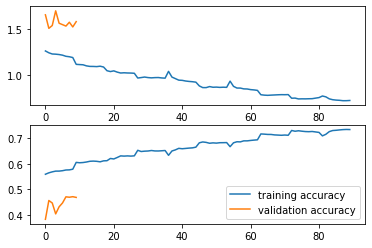

In [108]:
fig = plt.figure(num = 2)
fig1 = fig.add_subplot(2,1,1)
fig2 = fig.add_subplot(2,1,2)
fig1.plot(total_loss_train, label = 'training loss')
fig1.plot(total_loss_val, label = 'validation loss')
fig2.plot(total_acc_train, label = 'training accuracy')
fig2.plot(total_acc_val, label = 'validation accuracy')
plt.legend()
plt.show()

In [109]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

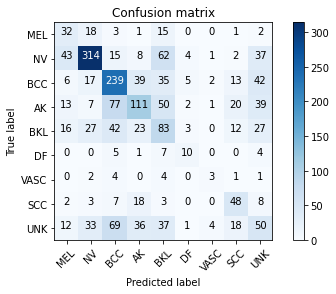

In [111]:
model.eval()
y_label = []
y_predict = []
with torch.no_grad():
    for i, data in enumerate(test_loader):
        images, labels = data
        N = images.size(0)
        images = Variable(images).to(device)
        outputs = model(images)
        prediction = outputs.max(1, keepdim=True)[1]
        y_label.extend(labels.cpu().numpy())
        y_predict.extend(np.squeeze(prediction.cpu().numpy().T))

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_label, y_predict)
# plot the confusion matrix
plot_labels = lesion_category.keys()
plot_confusion_matrix(confusion_mtx, plot_labels)

In [112]:
# Generate a classification report
report = classification_report(y_label, y_predict, target_names=plot_labels)
print(report)

              precision    recall  f1-score   support

         MEL       0.26      0.44      0.33        72
          NV       0.75      0.65      0.69       486
         BCC       0.52      0.60      0.56       398
          AK       0.47      0.35      0.40       320
         BKL       0.28      0.36      0.31       233
          DF       0.40      0.37      0.38        27
        VASC       0.27      0.20      0.23        15
         SCC       0.42      0.54      0.47        89
         UNK       0.24      0.19      0.21       260

    accuracy                           0.47      1900
   macro avg       0.40      0.41      0.40      1900
weighted avg       0.48      0.47      0.47      1900



Text(0, 0.5, 'Fraction classified incorrectly')

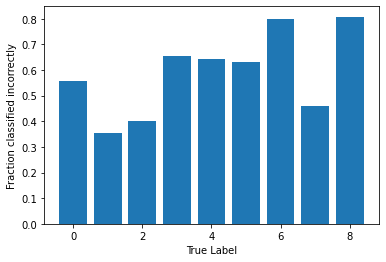

In [116]:
label_frac_error = 1 - np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=1)
plt.bar(np.arange(9),label_frac_error)
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')